# Transfer learning with MobileNetV2

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-04-26 20:53:58.914642: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:53:59.222576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 20:53:59.222613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 20:53:59.285565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 20:53:59.419327: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:53:59.420868: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 1003 files belonging to 2 classes.
Using 803 files for training.
Using 200 files for validation.


2024-04-26 20:54:05.672360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 20:54:05.672708: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


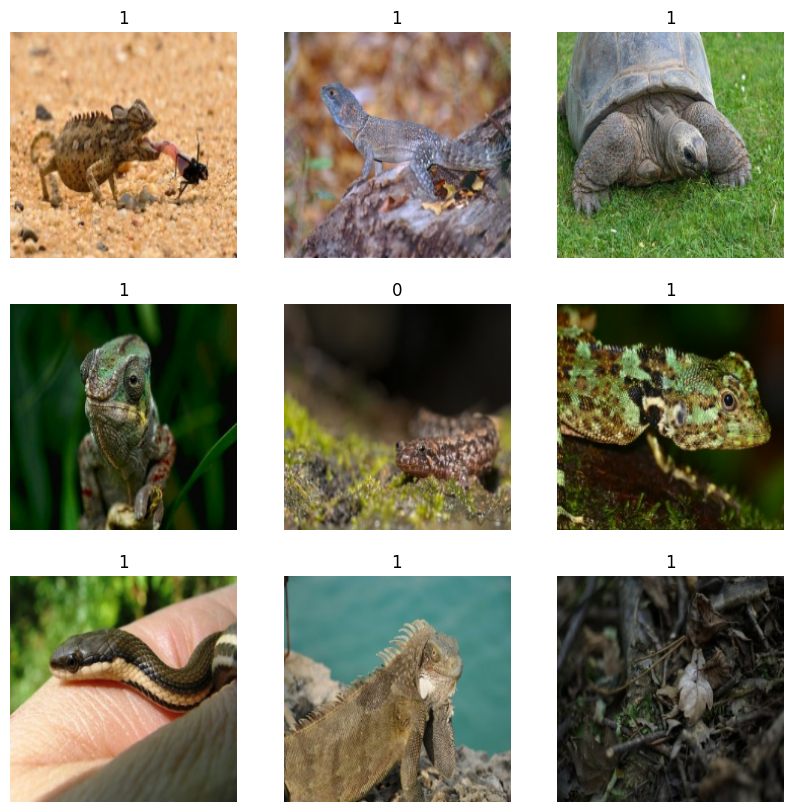

In [2]:
import DataLoader

train_ds, val_ds = DataLoader.load_image_dataset("reptile_amphibian_pics")

DataLoader.show_images(train_ds)


In [3]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import keras
from keras import layers

def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    # input layer and mobilenetv2 backbone and dropout
    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    # global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    # another dropout
    x = layers.Dropout(0.25)(x)

    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    # Define the model
    model_2 = keras.Model(inputs, outputs, name="transfer_model")

    return model_2

# Create the transfer model with MobileNetV2 backbone
image_size = (224, 224)
model_2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)


In [4]:
epochs =10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_2.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model_2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
81/81 [==============================] - 15s 157ms/step - loss: 0.5275 - acc: 0.7098 - val_loss: 0.3880 - val_acc: 0.8850
Epoch 2/10
81/81 [==============================] - 13s 157ms/step - loss: 0.3732 - acc: 0.8443 - val_loss: 0.3112 - val_acc: 0.9000
Epoch 3/10
81/81 [==============================] - 11s 137ms/step - loss: 0.3056 - acc: 0.8941 - val_loss: 0.2777 - val_acc: 0.9150
Epoch 4/10
81/81 [==============================] - 11s 135ms/step - loss: 0.2639 - acc: 0.9166 - val_loss: 0.2592 - val_acc: 0.9150
Epoch 5/10
81/81 [==============================] - 11s 135ms/step - loss: 0.2360 - acc: 0.9328 - val_loss: 0.2491 - val_acc: 0.9100
Epoch 6/10
81/81 [==============================] - 14s 175ms/step - loss: 0.2159 - acc: 0.9203 - val_loss: 0.2408 - val_acc: 0.9200
Epoch 7/10
81/81 [==============================] - 14s 171ms/step - loss: 0.2020 - acc: 0.9390 - val_loss: 0.2355 - val_acc: 0.9200
Epoch 8/10
81/81 [==============================] - 12s 146ms/step - 

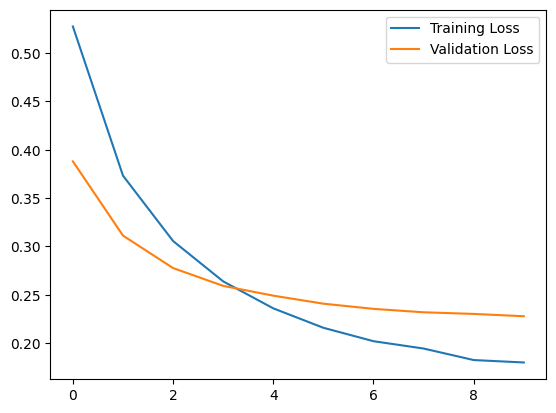

In [7]:

plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

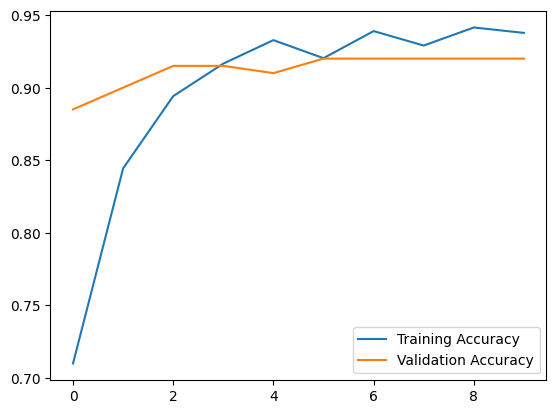

In [8]:

plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

In [5]:
# Save the model with keras
model_2.save("my_model3.keras")

# Data Augmentation
+ Random Flip and Rotation from Dr.Farbin's example
+ Random Translation
+ Random Zoom

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    layers.RandomZoom(height_factor=0.4, width_factor=0.4), 
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

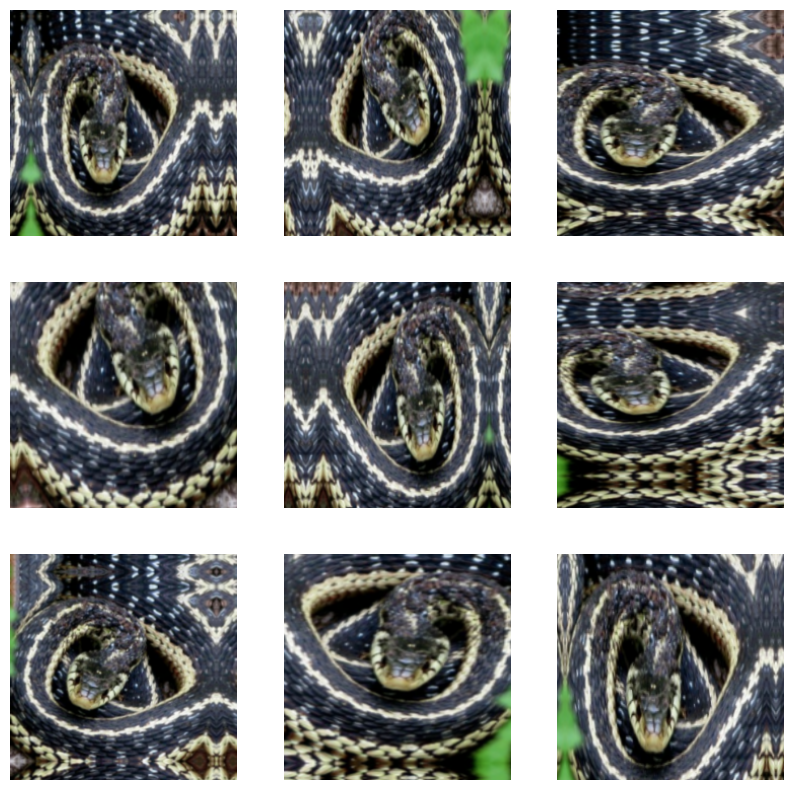

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [11]:
augmented_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_augmented_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [12]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model on augmented dataset
history = model_2.fit(augmented_ds, validation_data=val_augmented_ds, epochs=10, batch_size=32)  # Adjust epochs as needed


Epoch 1/10
81/81 [==============================] - 16s 177ms/step - loss: 1.4220 - accuracy: 0.8742 - val_loss: 1.4893 - val_accuracy: 0.8750
Epoch 2/10
81/81 [==============================] - 14s 177ms/step - loss: 1.4730 - accuracy: 0.8742 - val_loss: 1.2118 - val_accuracy: 0.8950
Epoch 3/10
81/81 [==============================] - 15s 186ms/step - loss: 1.5391 - accuracy: 0.8580 - val_loss: 1.2365 - val_accuracy: 0.8800
Epoch 4/10
81/81 [==============================] - 15s 181ms/step - loss: 1.2170 - accuracy: 0.8854 - val_loss: 1.5560 - val_accuracy: 0.8400
Epoch 5/10
81/81 [==============================] - 15s 183ms/step - loss: 1.2628 - accuracy: 0.8742 - val_loss: 1.2119 - val_accuracy: 0.8800
Epoch 6/10
81/81 [==============================] - 15s 188ms/step - loss: 1.3584 - accuracy: 0.8817 - val_loss: 1.1955 - val_accuracy: 0.9100
Epoch 7/10
81/81 [==============================] - 15s 188ms/step - loss: 0.9428 - accuracy: 0.9103 - val_loss: 1.2607 - val_accuracy: 0.8600

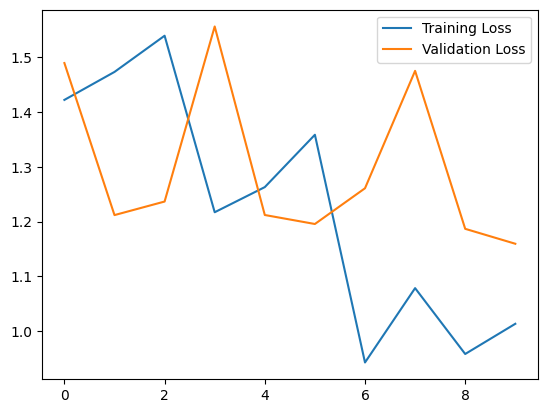

In [13]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

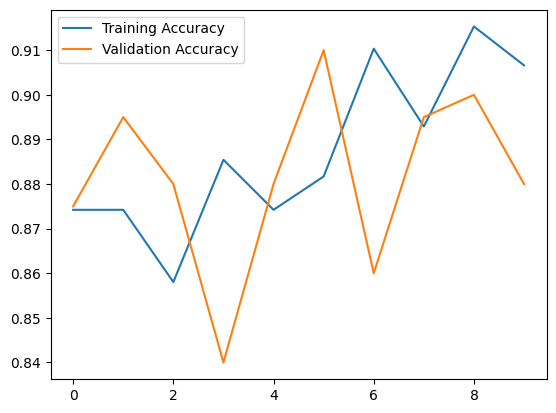

In [14]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Accuracy")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Accuracy")
plt.legend()

In [15]:
model_2.save("my_model4.keras")

# Comparisons

**Model trained without augmented data**  
final training accuracy: 0.9377 and training loss: 0.1800
final val accuracy: 0.9200 and val loss: 0.2278

+ This model has good accuracy and low loss values. It is performing very well.

**Model trained with augmented data**  
final training accuracy: 0.9066 and training loss: 1.0134
final val accuracy: 0.8800 and val loss: 1.1594

+ For this model the accuracy is good but not as high as the first model. However, the loss and accuracy curve for the model trained on augmented data seems to be very jumpy. It has high accuracy then falls, or has low loss and then it jumps up. This means that there needs to be more hyperparameter tuning to things like batch size or learning rate.

The model trained on the original image dataset ended with a higher training accuracy as well as a lower loss value, indicating that without using augmented data for training, the transfer learning model performed better. 
